<a href="https://colab.research.google.com/github/trista-chen-29/ai-ml-workshop-practice/blob/main/Classical_ML_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical ML Workshop**

Today, we're going to focus on K-Nearest Neighbors, which is a simple, non-parametric, supervised machine learning method used for classification and regression.

---
KNN classifies data points by identifying the nearest neighbors to a new, unseen input based on proximity (usually Euclidean distance) and assigning the class with the most votes among them. This is the same distance formula you've all learned in your high school math classes.

Dataset: https://archive.ics.uci.edu/dataset/53/iris

Step 1: Let's import our libraries

In [ ]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

Step 2: Load the cleaned data

In [ ]:
# ===============================
# LOAD IRIS DATASET
# ===============================

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# Column names (UCI dataset has no header row)
cols = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]

df = pd.read_csv(url, names=cols)

print(df.shape)
df.head()

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Step 3: Separate features and target

In [ ]:
X = df.drop(columns=["class"])
y = df["class"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", y.unique())

X shape: (150, 4)
y shape: (150,)
Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


Step 4: Train / Validation / Test Split

In [ ]:
# First: Train+Val vs Test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second: Train vs Validation (75/25 of temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (90, 4)
Val: (30, 4)
Test: (30, 4)


HYPERPARAMETER TUNING

Step 5: Feature Scaling

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaling complete") # check

Scaling complete


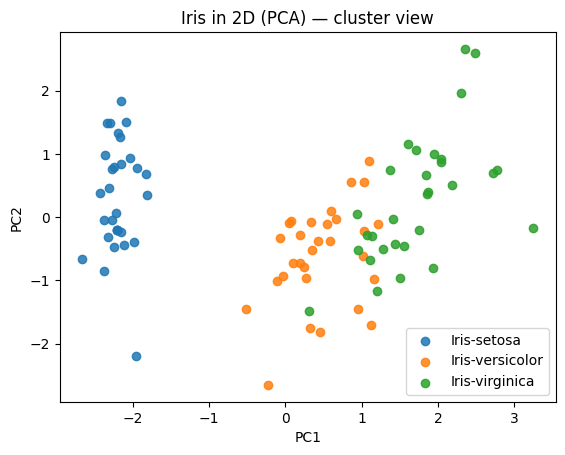

In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on TRAIN only (good practice)
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d  = pca.transform(X_test_scaled)

plt.figure()
for cls in np.unique(y_train):
    mask = (y_train.to_numpy() == cls)
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], label=str(cls), alpha=0.85)

plt.title("Iris in 2D (PCA) — cluster view")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [ ]:
# STEP 5 — Interactive KNN Hyperparameter Tuning (Train + Validation)

import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# --- Hyperparameter Controls ---
k_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=30,
    step=1,
    description='K'
)

weights_dropdown = widgets.Dropdown(
    options=['uniform', 'distance'],
    value='uniform',
    description='Weights'
)

metric_dropdown = widgets.Dropdown(
    options=['minkowski', 'euclidean', 'manhattan'],
    value='minkowski',
    description='Metric'
)

train_button = widgets.Button(description="Train Model", button_style="success")
output = widgets.Output()

# --- Training Function ---
def train_knn_model(b):
    with output:
        clear_output()

        model = KNeighborsClassifier(
            n_neighbors=k_slider.value,
            weights=weights_dropdown.value,
            metric=metric_dropdown.value
        )

        # Fit on TRAIN only
        model.fit(X_train_scaled, y_train)

        # Evaluate on TRAIN + VAL (NOT test)
        train_preds = model.predict(X_train_scaled)
        val_preds   = model.predict(X_val_scaled)

        train_acc = accuracy_score(y_train, train_preds)
        val_acc   = accuracy_score(y_val, val_preds)

        print("Selected Hyperparameters:")
        print("K:", k_slider.value)
        print("Weights:", weights_dropdown.value)
        print("Metric:", metric_dropdown.value)

        print("\nTrain Accuracy:", round(train_acc, 4))
        print("Val Accuracy:", round(val_acc, 4))

train_button.on_click(train_knn_model)

display(k_slider, weights_dropdown, metric_dropdown, train_button, output)

IntSlider(value=5, description='K', max=30, min=1)

Dropdown(description='Weights', options=('uniform', 'distance'), value='uniform')

Dropdown(description='Metric', options=('minkowski', 'euclidean', 'manhattan'), value='minkowski')

Button(button_style='success', description='Train Model', style=ButtonStyle())

Output()

Step 6: Train Baseline KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

val_preds = knn.predict(X_val_scaled)
print("Baseline Validation Accuracy:", accuracy_score(y_val, val_preds))

Baseline Validation Accuracy: 0.9666666666666667


Step 7: Tune K with Validation Set

Best K: 2 Val Acc: 0.9666666666666667


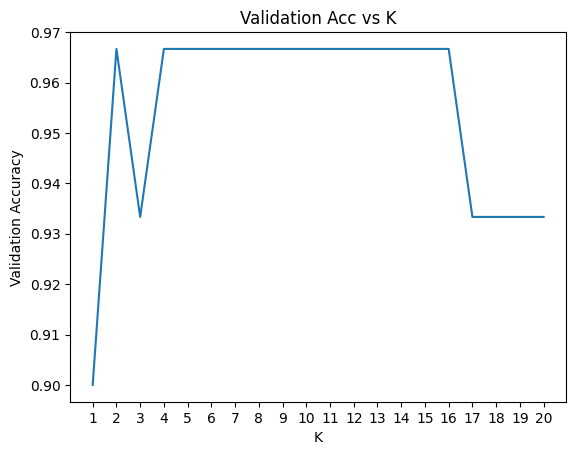

In [ ]:
k_values = range(1, 21)
val_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    val_scores.append(accuracy_score(y_val, preds))

best_k = k_values[np.argmax(val_scores)]
print("Best K:", best_k, "Val Acc:", max(val_scores))
plt.plot(list(k_values), val_scores)
plt.xlabel("K")
plt.ylabel("Validation Accuracy")
plt.title("Validation Acc vs K")
plt.xticks(k_values)
plt.show()

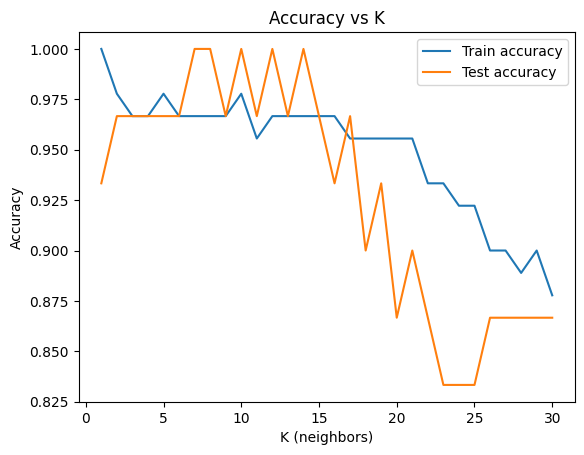

In [ ]:
from sklearn.metrics import accuracy_score

ks = range(1, 31)
train_acc, test_acc = [], []

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    train_acc.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test_scaled)))

plt.figure()
plt.plot(list(ks), train_acc, label="Train accuracy")
plt.plot(list(ks), test_acc, label="Test accuracy")
plt.title("Accuracy vs K")
plt.xlabel("K (neighbors)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Step 8: Final Test Evaluation

In [ ]:
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train_scaled, y_train)

test_preds = final_model.predict(X_test_scaled)
print("TEST Accuracy:", accuracy_score(y_test, test_preds))

TEST Accuracy: 0.9666666666666667


Step 9: Confusion Matrix + Classification Report

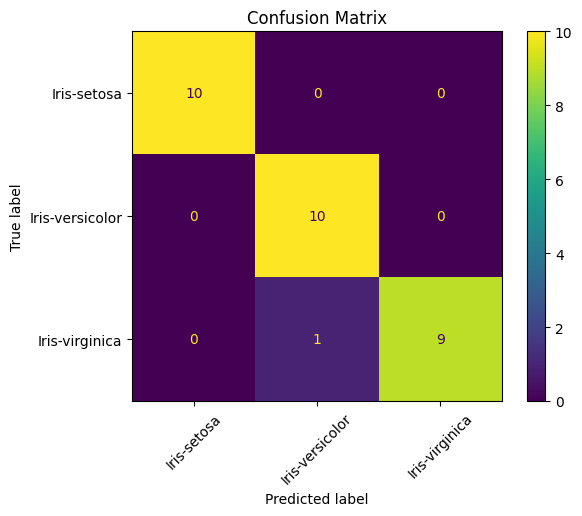

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



In [ ]:
cm = confusion_matrix(y_test, test_preds, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(values_format="d", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, test_preds))

Questions to think about:

---

Activity 1 — Explore K

Start with K = 1.
Click Train.
Write down Train Accuracy and Test Accuracy.

Then:

Increase K slowly (3, 5, 10, 20…).
Observe what happens to both accuracies.

What happens when K = 1?

Why is train accuracy usually very high?

Does test accuracy increase or decrease?

At what K does performance peak?

🔹 Activity 2 — Compare Weights


Keep K fixed at a reasonable value (like 5 or 10).
Switch between uniform and distance.


Does weighting by distance improve accuracy?

Why might closer neighbors matter more?

🔹 Activity 3 — Record Results

Create a mini table:

| K  | Train Acc | Test Acc |
| -- | --------- | -------- |
| 1  |           |          |
| 3  |           |          |
| 5  |           |          |
| 10 |           |          |


Answer : Where does overfitting stop? Where does underfitting begin?

🔹 Activity 4 — Apply this algorithm on a different dataset
https://www.kaggle.com/datasets/bharath011/heart-disease-classification-dataset


Choose your own:
- K
- weights
- metric
- Justify your choice, Report their final performance. Explain why you chose those hyperparameters.